This project was done as a Complex Engineering Project for Advanced Linear Algebra Course

Nauman Ali Murad - GIK Institute

Summary Statistics:
             Cement  Blast Furnace Slag      Fly Ash        Water  \
count  1030.000000         1030.000000  1030.000000  1030.000000   
mean    281.167864           73.895825    54.188350   181.567282   
std     104.506364           86.279342    63.997004    21.354219   
min     102.000000            0.000000     0.000000   121.800000   
25%     192.375000            0.000000     0.000000   164.900000   
50%     272.900000           22.000000     0.000000   185.000000   
75%     350.000000          142.950000   118.300000   192.000000   
max     540.000000          359.400000   200.100000   247.000000   

       Superplasticizer  Coarse Aggregate  Fine Aggregate          Age  \
count       1030.000000       1030.000000     1030.000000  1030.000000   
mean           6.204660        972.918932      773.580485    45.662136   
std            5.973841         77.753954       80.175980    63.169912   
min            0.000000        801.000000      594.000000     1.000000

<Figure size 1200x800 with 0 Axes>

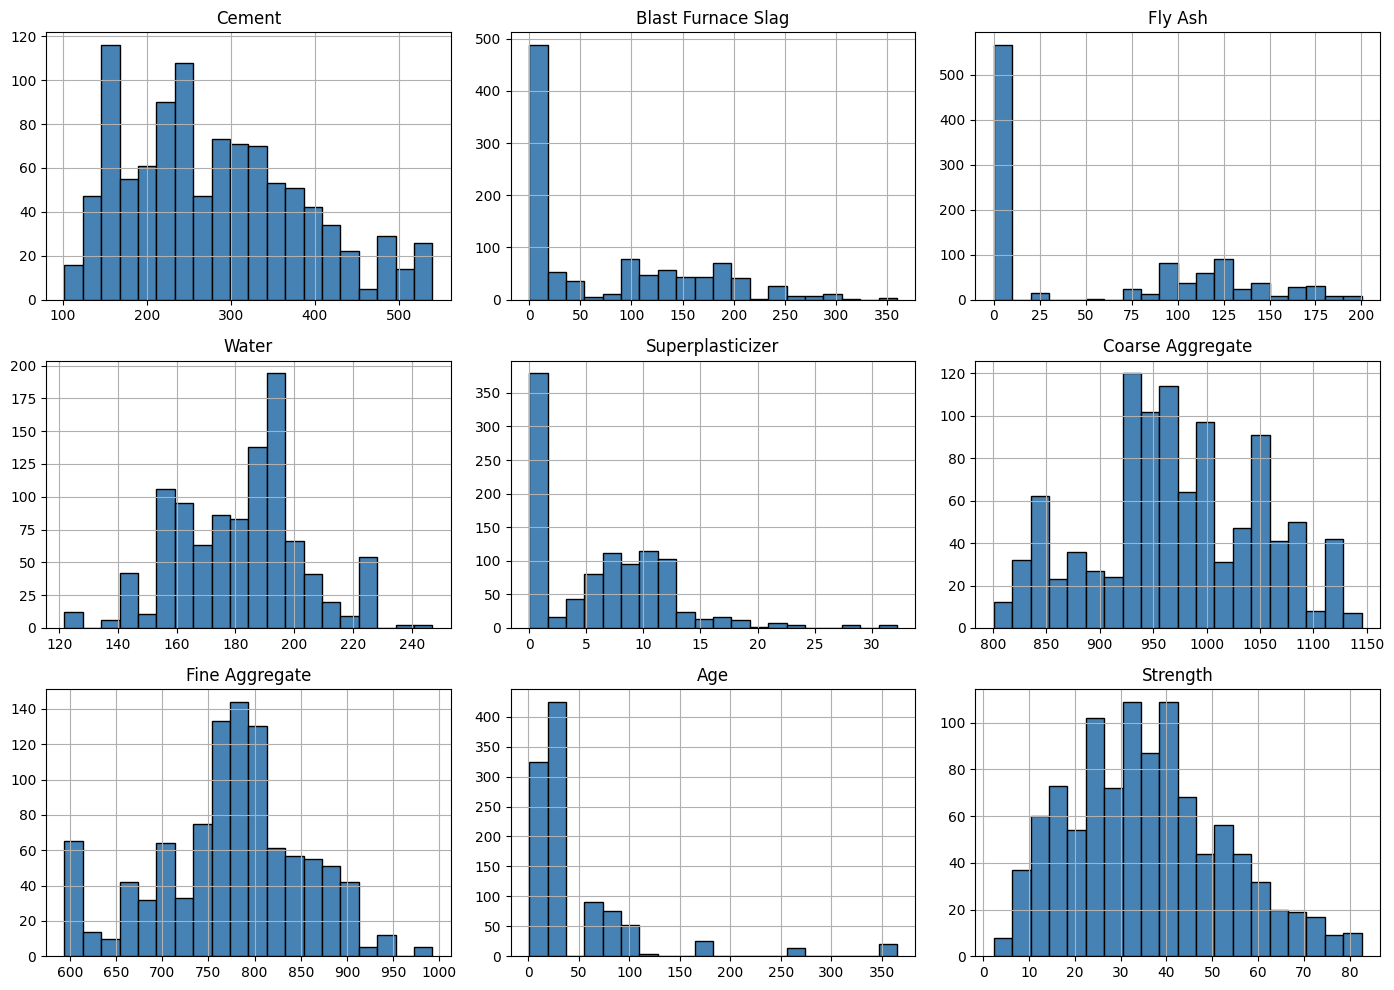

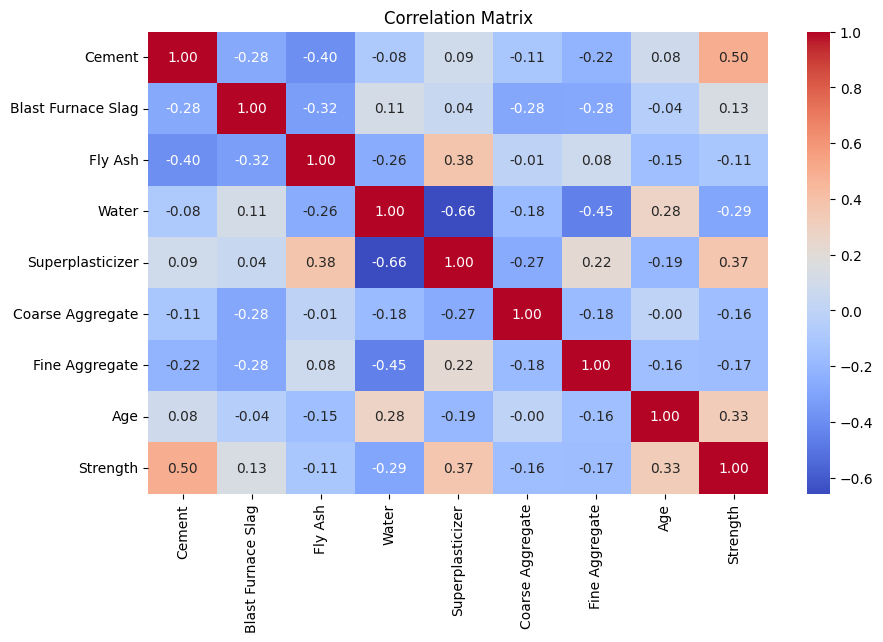

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

# Data Import and Preprocessing
data_path = '/kaggle/input/concrete-data/concrete_data.csv'
data = pd.read_csv(data_path)

# Check for missing values
data.fillna(data.mean(), inplace=True)

# Ensure correct data types
data = data.apply(pd.to_numeric, errors='coerce')

# Exploratory Data Analysis (EDA)
# Summary statistics
print("Summary Statistics:\n", data.describe())

# Visualize distributions
plt.figure(figsize=(12, 8))
data.hist(bins=20, figsize=(14, 10), color='steelblue', edgecolor='black')
plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

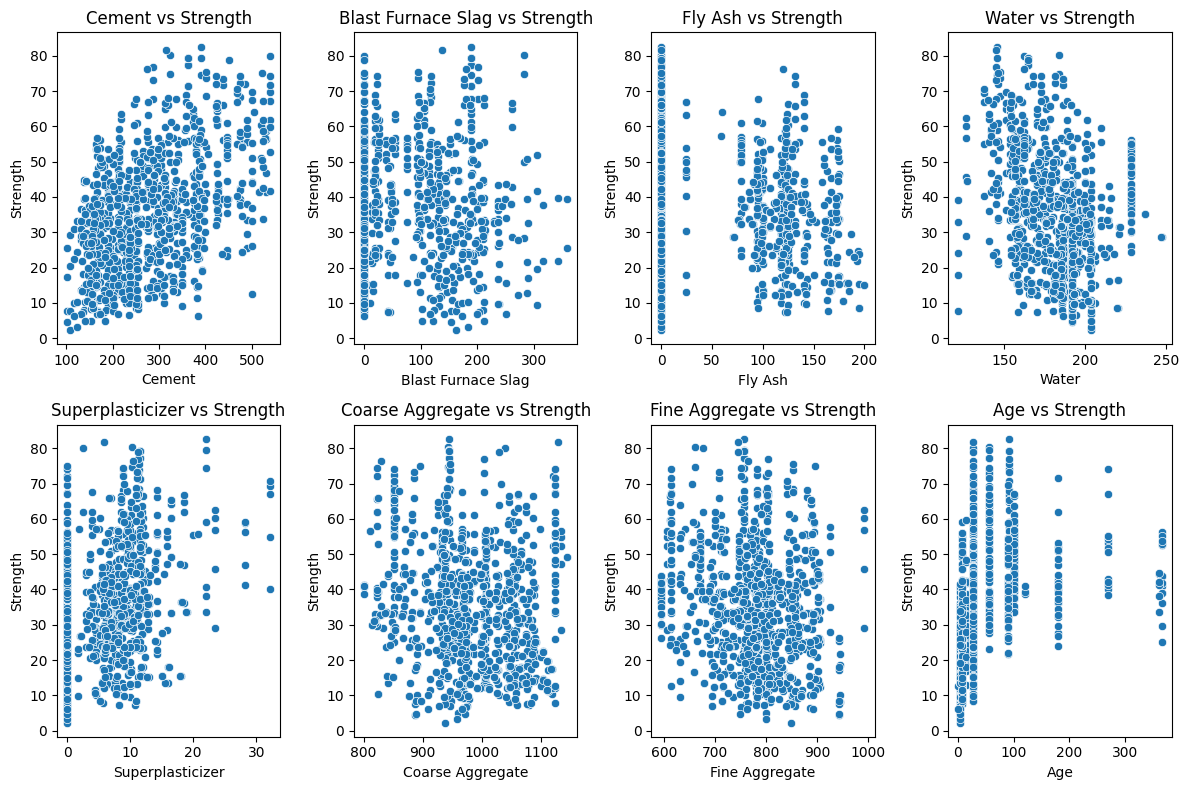

In [20]:
# Scatter plots for ingredients vs. Strength
columns = data.columns[:-1]  # Exclude 'Strength'
plt.figure(figsize=(12, 8))
for i, column in enumerate(columns, 1):
    plt.subplot(2, 4, i)
    sns.scatterplot(x=data[column], y=data['Strength'])
    plt.title(f'{column} vs Strength')
plt.tight_layout()
plt.show()

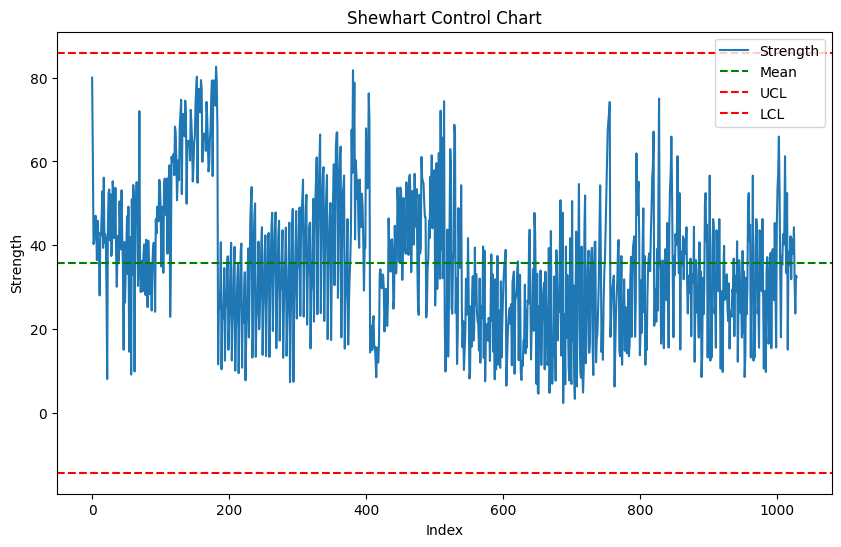

In [21]:
# Shewhart Control Chart
mean_strength = data['Strength'].mean()
std_strength = data['Strength'].std()
upper_control_limit = mean_strength + 3 * std_strength
lower_control_limit = mean_strength - 3 * std_strength

plt.figure(figsize=(10, 6))
plt.plot(data['Strength'], label='Strength')
plt.axhline(mean_strength, color='green', linestyle='--', label='Mean')
plt.axhline(upper_control_limit, color='red', linestyle='--', label='UCL')
plt.axhline(lower_control_limit, color='red', linestyle='--', label='LCL')
plt.xlabel('Index')
plt.ylabel('Strength')
plt.title('Shewhart Control Chart')
plt.legend()
plt.show()

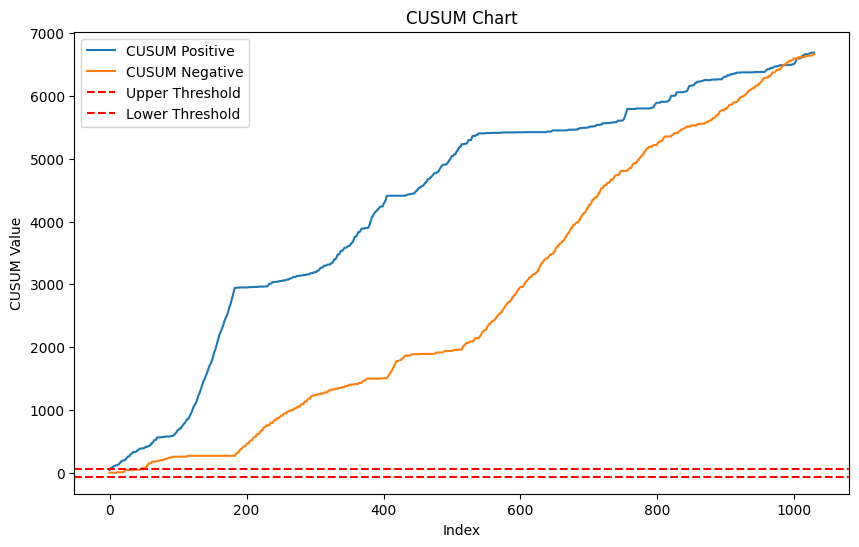

In [22]:
threshold = 4 * data['Strength'].std()  # Dynamic threshold
target_mean = data['Strength'].mean()
k = 0.5  # Reference value for small shift detection

# Positive and Negative CUSUM
cusum_pos = np.cumsum(np.maximum(0, data['Strength'] - target_mean - k))
cusum_neg = np.cumsum(np.maximum(0, target_mean - data['Strength'] - k))

plt.figure(figsize=(10, 6))
plt.plot(cusum_pos, label='CUSUM Positive')
plt.plot(cusum_neg, label='CUSUM Negative')
plt.axhline(threshold, color='red', linestyle='--', label='Upper Threshold')
plt.axhline(-threshold, color='red', linestyle='--', label='Lower Threshold')
plt.xlabel('Index')
plt.ylabel('CUSUM Value')
plt.title('CUSUM Chart')
plt.legend()
plt.show()

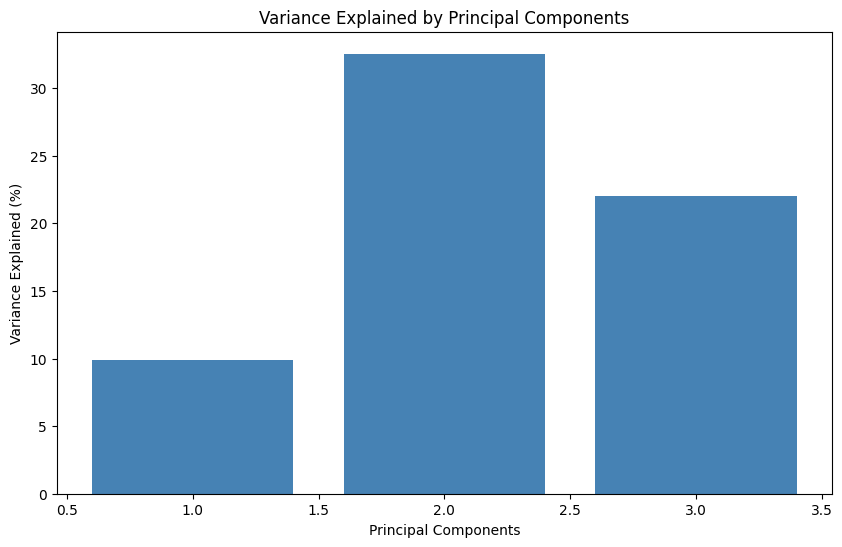

In [23]:
# Singular Value Decomposition (SVD)
features = data.iloc[:, :-1]
svd = TruncatedSVD(n_components=3)
svd_result = svd.fit_transform(features)

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(svd.explained_variance_ratio_) + 1), svd.explained_variance_ratio_ * 100, color='steelblue')
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained (%)')
plt.title('Variance Explained by Principal Components')
plt.show()

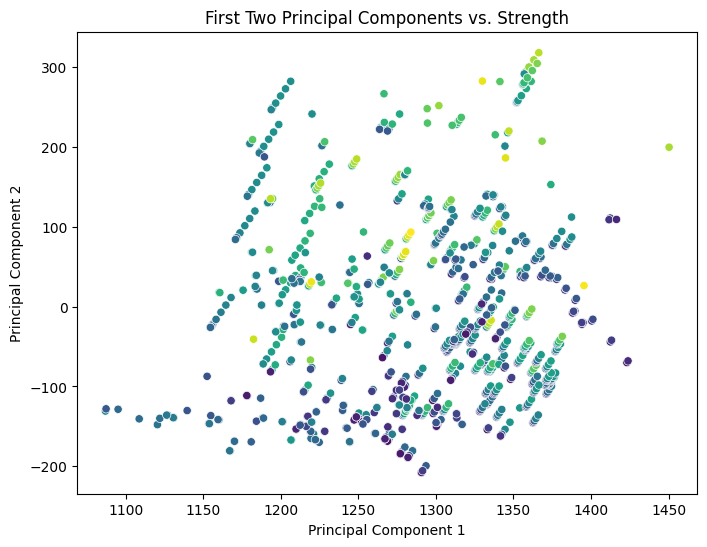

In [24]:
# Scatter plot of first two principal components
plt.figure(figsize=(8, 6))
sns.scatterplot(x=svd_result[:, 0], y=svd_result[:, 1], hue=data['Strength'], palette='viridis', legend=None)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('First Two Principal Components vs. Strength')
plt.show()

Random Forest Model R-squared: 0.88
Random Forest Model Mean Absolute Error: 3.74


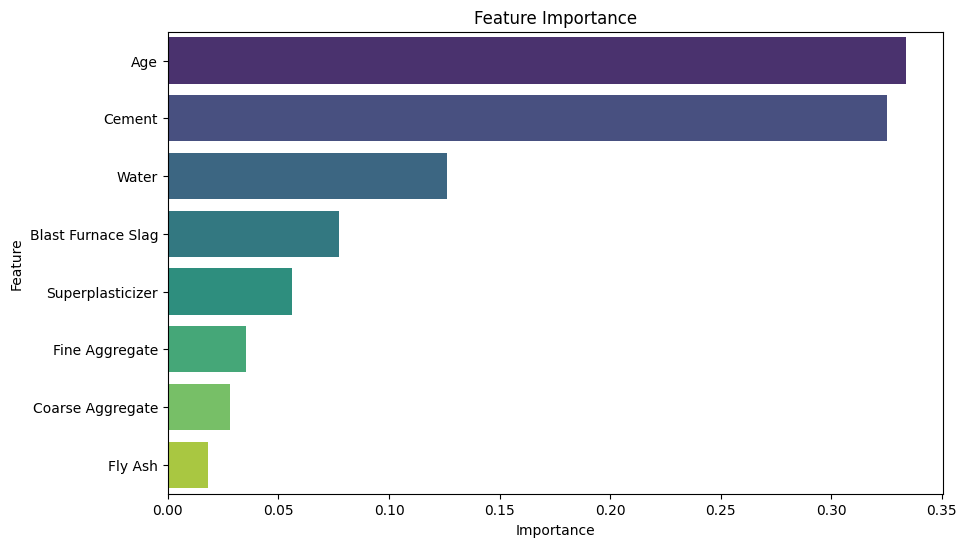

In [25]:
# Predictive Modeling
X = features
y = data['Strength']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Model Performance
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Random Forest Model R-squared: {r2:.2f}")
print(f"Random Forest Model Mean Absolute Error: {mae:.2f}")

# Feature Importance
feature_importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance')
plt.show()